# Compiler examples

## Reshape and reduce

B : tensor([ 0.2342,  0.4952,  0.1764,  0.4940, -0.4193,  0.4248,  0.7571, -1.3076,
         0.3022,  0.6465,  0.5334, -0.7053,  0.7301,  0.7947, -0.0918,  1.4359,
        -0.3691, -0.0425, -1.0072,  0.9076,  1.4813, -0.3896, -0.5602, -0.0443,
         0.6140, -0.1764, -1.5079, -2.4066, -1.0323,  0.2335,  0.7035,  0.7035,
         0.0339, -0.7043,  1.0959,  0.1929,  1.0409,  0.4782, -0.0096, -1.1259,
        -0.8358, -0.7404,  0.3247,  0.9100, -1.4410,  0.5733,  0.8124,  1.0996,
        -0.3094, -0.2741, -1.0941, -0.9291,  0.3255, -1.1394, -1.6715,  0.1187,
         1.3968,  0.3043, -0.1645,  0.6633])
C : tensor([[ 0.2342,  0.4952,  0.1764,  0.4940, -0.4193,  0.4248,  0.7571, -1.3076,
          0.3022,  0.6465],
        [ 0.5334, -0.7053,  0.7301,  0.7947, -0.0918,  1.4359, -0.3691, -0.0425,
         -1.0072,  0.9076],
        [ 1.4813, -0.3896, -0.5602, -0.0443,  0.6140, -0.1764, -1.5079, -2.4066,
         -1.0323,  0.2335],
        [ 0.7035,  0.7035,  0.0339, -0.7043,  1.0959,  0.192

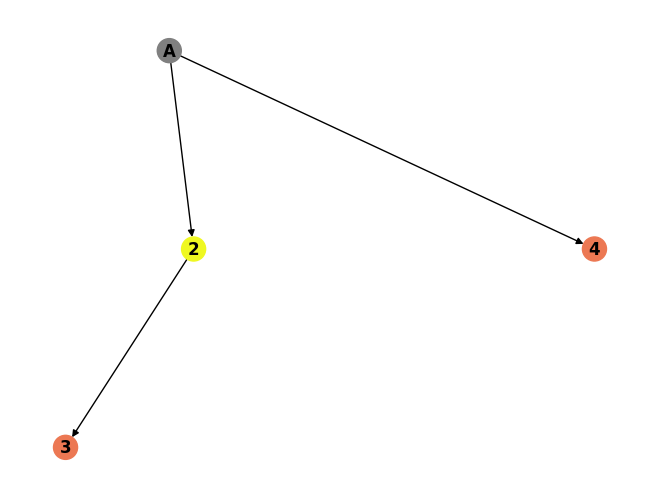

In [1]:
%load_ext autoreload
%autoreload 2
import torch

import tensorcraft as tc

join_and_split_axis_program = tc.compile("""
B[(ijk)] = A[i,j,k]
C[i,j] = B[(ij)]                                       
Row[j] = A[0,j,k]
""")

A = torch.randn((3, 4, 5))
expected_B = A.reshape(60)
expected_C = expected_B.reshape(6, 10)
outputs = join_and_split_axis_program.execute(
    inputs={"A": A}, shape_hints={"B": (60,), "C": (6, 10), "Row": (4,)}
)

print("B :", outputs["B"])
print("C :", outputs["C"])
print("Row :", outputs["Row"])

print("B ~= expected_B: ", torch.allclose(outputs["B"], expected_B))
print("C ~= expected_C: ", torch.allclose(outputs["C"], expected_C))

tc.viz.draw_program_graph(join_and_split_axis_program)

## Expressions with mutiple tensor orders

Positioning nodes


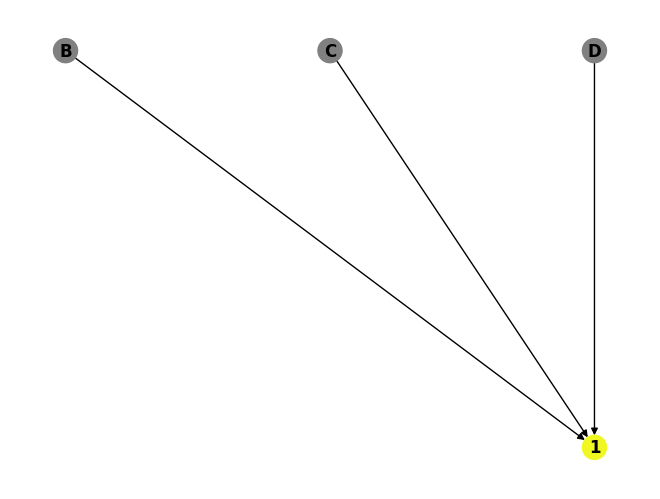

In [2]:
small_program = tc.compile("A[i,j] = B[i,j] + B[j,i] + sin(C[i]) + D + i")
# small_program = tc.compile("A[i,j] = sin(B[i,j] + C[i]) + D + i")
tc.viz.draw_program_graph(small_program)

['B[i,j]', 'B[j,i]', '+ 0', 'C[i]', 'sin 0', '+ 1', 'D[]', '+ 2', Token('INDEXVAR', 'i'), '+ 3']
Positioning nodes


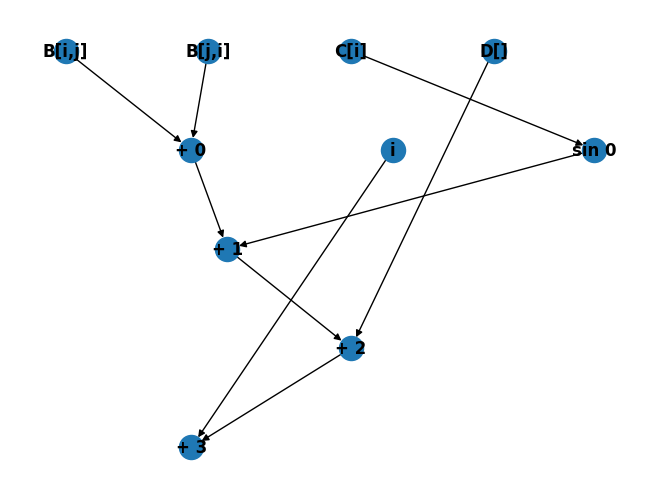

In [3]:
print(small_program.tensor_expressions[1].op_graph.nodes())
tc.viz.draw_expression_graph(small_program.tensor_expressions[1])

In [4]:
B = torch.ones((10, 10))
C = torch.ones(10) + 10
expected = B + B.T + torch.sin(C) + 100 + torch.arange(10).reshape(-1, 1)
result = small_program.execute(
    {"B": B, "C": C, "D": torch.tensor(100)}, shape_hints={"A": (10, 10)}
)
print(expected)
print(result["A"])
torch.all(result["A"] == expected)

tensor([[101.0000, 101.0000, 101.0000, 101.0000, 101.0000, 101.0000, 101.0000,
         101.0000, 101.0000, 101.0000],
        [102.0000, 102.0000, 102.0000, 102.0000, 102.0000, 102.0000, 102.0000,
         102.0000, 102.0000, 102.0000],
        [103.0000, 103.0000, 103.0000, 103.0000, 103.0000, 103.0000, 103.0000,
         103.0000, 103.0000, 103.0000],
        [104.0000, 104.0000, 104.0000, 104.0000, 104.0000, 104.0000, 104.0000,
         104.0000, 104.0000, 104.0000],
        [105.0000, 105.0000, 105.0000, 105.0000, 105.0000, 105.0000, 105.0000,
         105.0000, 105.0000, 105.0000],
        [106.0000, 106.0000, 106.0000, 106.0000, 106.0000, 106.0000, 106.0000,
         106.0000, 106.0000, 106.0000],
        [107.0000, 107.0000, 107.0000, 107.0000, 107.0000, 107.0000, 107.0000,
         107.0000, 107.0000, 107.0000],
        [108.0000, 108.0000, 108.0000, 108.0000, 108.0000, 108.0000, 108.0000,
         108.0000, 108.0000, 108.0000],
        [109.0000, 109.0000, 109.0000, 109.0000,

tensor(True)

## Min reduction

In [5]:
min_red_program = tc.compile("""
Min[j] = 10000
Min[j] += (X[i,j] < Min[j]) * (X[i,j] - Min[j])
""")

X = torch.randn(200, 10)
expected = torch.min(X, dim=0).values
print(expected)

result = min_red_program.execute({"X": X}, shape_hints={"Min": (10,)})
print(result["Min"])
print(torch.all(result["Min"] == expected))

tensor([-2.5577, -3.0164, -2.8586, -2.6852, -2.2885, -3.9102, -2.5885, -2.4757,
        -2.7841, -2.2794])
tensor([-2.5577, -3.0164, -2.8586, -2.6852, -2.2885, -3.9102, -2.5885, -2.4757,
        -2.7841, -2.2794], dtype=torch.float64)
tensor(True)


## KMeans Kernel

Reduction last
Reduction last
Reduction last
Dist ~= expected_Dist:  True
Min:  tensor([0.0000, 9.5052, 2.3395, 2.1527, 1.9707, 5.9331, 0.0000, 0.0000, 6.2204,
        4.9625, 7.5845, 6.5729, 0.0000, 3.8209, 4.4301, 7.8484, 7.9719, 3.0277,
        0.0000, 1.3576], dtype=torch.float64)
expected_min:  tensor([0.0000, 9.5052, 2.3395, 2.1527, 1.9707, 5.9331, 0.0000, 0.0000, 6.2204,
        4.9625, 7.5845, 6.5729, 0.0000, 3.8209, 4.4301, 7.8484, 7.9719, 3.0277,
        0.0000, 1.3576], dtype=torch.float64)
Min ~= expected_Min:  True
expected_Labels:  tensor([2, 3, 0, 3, 2, 3, 3, 0, 3, 3, 3, 4, 1, 1, 1, 4, 1, 3, 4, 3])
Labels:  tensor([ 2.,  3., -1.,  3.,  2.,  3.,  3.,  0.,  3.,  3.,  3.,  4.,  1.,  1.,
        -1.,  4., -1.,  3.,  4., -1.], dtype=torch.float64)
Labels ~= expected_Labels:  tensor(False)
Count ~= expected_Count:  tensor(False)
Update ~= expected_Update:  False
expected_Update: tensor([[ 0.5771,  0.4498, -2.0497,  0.7397, -1.0881],
        [-0.1836,  0.4123,  0.3092, -1.2594,

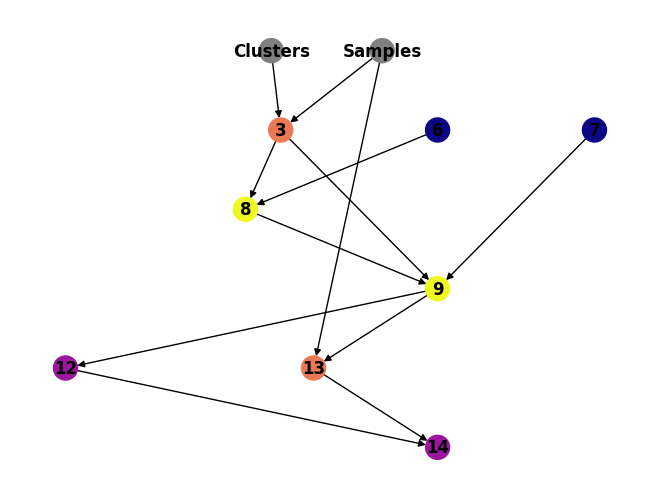

In [6]:
TOL = 1e-7

code = """
# Distance computation
Dist[j,k] += (Samples[j,l] - Clusters[k,l]) ^ 2

# Argmin
Min[j] = 1000
Labels[j] = -1
Min[j] += ( Dist[j,k] < Min[j] ) * ( Dist[j,k] - Min[j] )
Labels[j] += (Dist[j,k] == Min[j]) * (k - Labels[j])

# # Cluster update
Count[l] += (Labels[j] == l)
Update[l,k] += Samples[j,k] * (Labels[j] == l)
Update[l,k] = Update[l,k] / Count[l]
"""
kmeans_kernel = tc.compile(code)

n_samples = 20
sample_dim = 5
n_cluster = 5

Samples = torch.randn(n_samples, sample_dim, dtype=torch.float64)
Clusters = Samples[torch.randint(0, n_samples, (n_cluster,))]

# Compute expected labels
expected_Dist = torch.pow(torch.cdist(Samples, Clusters, p=2), 2)
expected_Min = torch.min(expected_Dist, axis=1).values
expected_Labels = expected_Dist.argmin(axis=1)

# Update cluster centers
expected_Count = torch.zeros(n_cluster, dtype=torch.float64)
expected_Update = torch.zeros((n_cluster, sample_dim), dtype=torch.float64)

for j in range(n_samples):
    l = expected_Labels[j]
    expected_Count[l] += 1
    expected_Update[l] += Samples[j]

expected_Update /= expected_Count.reshape(-1, 1)


outputs = kmeans_kernel.execute(
    inputs={"Samples": Samples, "Clusters": Clusters},
    shape_hints={
        "Dist": (n_samples, n_cluster),
        "Min": (n_samples,),
        "Labels": (n_samples,),
        "Count": (n_cluster,),
        "Update": (n_cluster, sample_dim),
    },
)
# print("Dist: ", outputs['Dist'])
# print("expected_Dist: ", expected_Dist)
print("Dist ~= expected_Dist: ", torch.allclose(outputs["Dist"], expected_Dist))

print("Min: ", outputs["Min"])
print("expected_min: ", expected_Min)
print("Min ~= expected_Min: ", torch.allclose(outputs["Min"], expected_Min))

print("expected_Labels: ", expected_Labels)
print("Labels: ", outputs["Labels"])
print("Labels ~= expected_Labels: ", torch.all(outputs["Labels"] == expected_Labels))

print("Count ~= expected_Count: ", torch.all(outputs["Count"] == expected_Count))
print("Update ~= expected_Update: ", torch.allclose(outputs["Update"], expected_Update))
print(f"expected_Update: {expected_Update}")
print(f"Update: {outputs['Update']}")

tc.viz.draw_program_graph(kmeans_kernel, color_by="opcount")

Positioning nodes


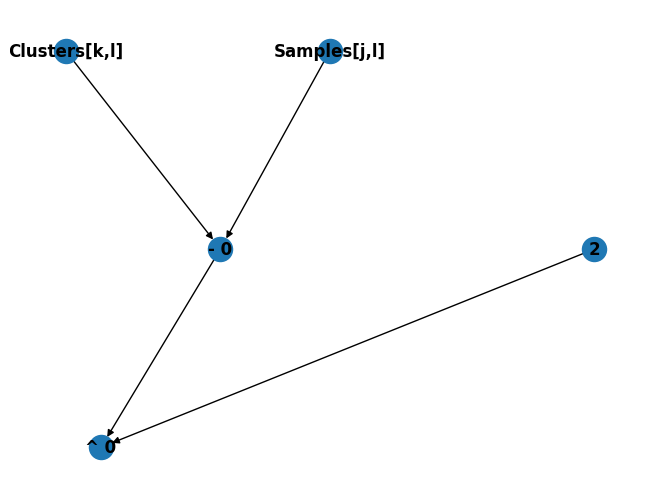

In [7]:
tc.viz.draw_expression_graph(kmeans_kernel.tensor_expressions[3])

## Conjugate Gradient

Positioning nodes


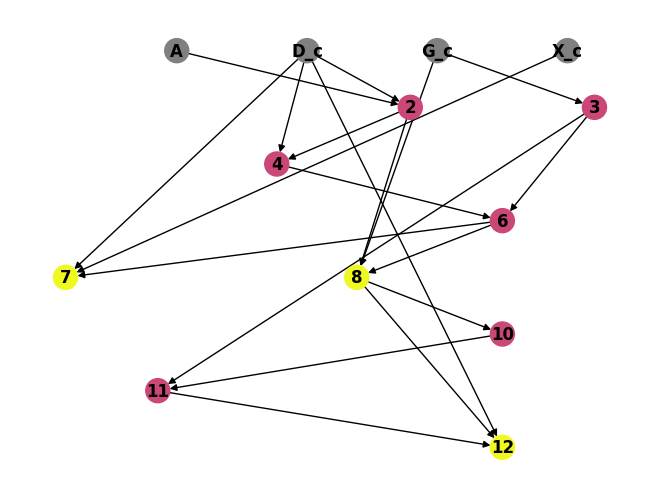

In [8]:
code = """
W_c[i] += A[i,j] * D_c[j]
Gamma_c += G_c[i] * G_c[i]
Theta_c += D_c[i] * W_c[i]

Alpha_c = Gamma_c / Theta_c
X_n[i] = X_c[i] + (Alpha_c * D_c[i])
G_n[i] = G_c[i] + (Alpha_c * W_c[i])

Gamma_n += G_n[i] * G_n[i]
Beta_n = Gamma_n / Gamma_c
Delta_n += (Beta_n * D_c[i]) - G_n[i]
"""
conjugate_gradient_kernel = tc.compile(code)

tc.viz.draw_program_graph(conjugate_gradient_kernel, color_by="opcount")

Positioning nodes


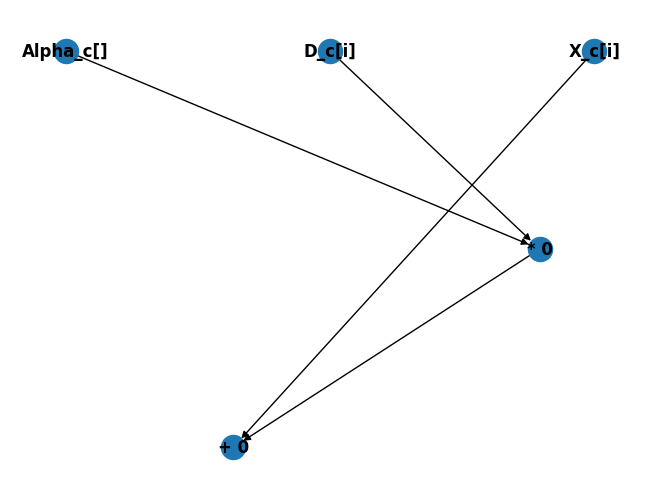

In [9]:
tc.viz.draw_expression_graph(conjugate_gradient_kernel.tensor_expressions[7])

## Transformer (Multi-Head Attention)

**Constants**

- B: Batch Size
- L: Sequence Lenght
- M: Embedding Size
- H: Number of Atte Heads
- E: Head Embedding Size (M / H)
- Sqe: sqrt(E)


**Inputs**

- X: Samples (B x L x M)
- W(q|k|v): Query/Key/Value Weight Matrix (H x M x E)
- Wo: Linear Layer (M x M)


Positioning nodes


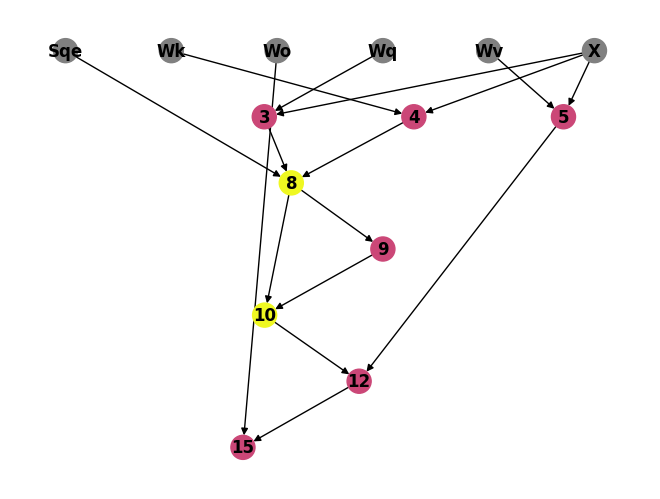

In [10]:
code = """
# Query, Key, Value
Q[i,j,k,l] += X[i,k,m] * Wq[j,m,l] # (B x H x L x E) 
K[i,j,k,l] += X[i,k,m] * Wk[j,m,l] # (B x H x L x E) 
V[i,j,k,l] += X[i,k,m] * Wv[j,m,l] # (B x H x L x E) 

# Attention
A[i,j,k,m] += (Q[i,j,k,l] * K[i,j,m,l]) / Sqe # (B x H x L x L)
Denom[i,j,k] += exp(A[i,j,k,m]) # (B x H x L)
Softmax[i,j,k,m] = exp(A[i,j,k,m]) / Denom[i,j,k] # (B x H x L x L)

Atte[i,j,(kl)] += Softmax[i,k,j,m] * V[i,k,m,l] # (B x L x M)

# Linear
Z[i,j,l] += Atte[i,j,k] * Wo[l,k] # (B x L x M)
"""
mha_kernel = tc.compile(code)

tc.viz.draw_program_graph(mha_kernel, color_by="opcount")

In [11]:
import math

import torch
from torch import nn

torch.set_default_dtype(torch.float64)


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [12]:
d_model = 64
num_heads = 8
seq_length = 5
batch_size = 3
head_dim = d_model // num_heads

model = MultiHeadAttention(d_model, num_heads)

print(model.W_q.weight.dtype)
W_q = (
    model.W_q.weight.clone()
    .detach()
    .reshape(num_heads, head_dim, d_model)
    .permute(0, 2, 1)
)
W_k = (
    model.W_k.weight.clone()
    .detach()
    .reshape(num_heads, head_dim, d_model)
    .permute(0, 2, 1)
)
W_v = (
    model.W_v.weight.clone()
    .detach()
    .reshape(num_heads, head_dim, d_model)
    .permute(0, 2, 1)
)
W_o = model.W_o.weight.clone().detach()

X = torch.randn(batch_size, seq_length, d_model, dtype=torch.float64)

expected_result = model(X, X, X)
print(expected_result.shape)

outputs = mha_kernel.execute(
    inputs={
        "X": X,
        "Wq": W_q,
        "Wk": W_k,
        "Wv": W_v,
        "Wo": W_o,
        "Sqe": torch.tensor(math.sqrt(d_model // num_heads)),
    },
    shape_hints={
        "Q": (batch_size, num_heads, seq_length, head_dim),
        "K": (batch_size, num_heads, seq_length, head_dim),
        "V": (batch_size, num_heads, seq_length, head_dim),
        "A": (batch_size, num_heads, seq_length, seq_length),
        "Denom": (batch_size, num_heads, seq_length),
        "Softmax": (batch_size, num_heads, seq_length, seq_length),
        "Atte": (batch_size, seq_length, d_model),
        "Z": (batch_size, seq_length, d_model),
    },
)
print(outputs["Z"].shape)
print(torch.allclose(outputs["Z"], expected_result, atol=1e-8))

torch.float64
torch.Size([3, 5, 64])
Reduction last
Reduction last
Reduction last
Reduction last
Reduction last
Reduction last
Reduction last
torch.Size([3, 5, 64])
True


In [13]:
tol = 1e-6
expected_Q = model.split_heads(model.W_q(X))
print("Q close", torch.allclose(outputs["Q"], expected_Q, atol=tol))

expected_K = model.split_heads(model.W_k(X))
print("K close", torch.allclose(outputs["K"], expected_K, atol=tol))

expected_V = model.split_heads(model.W_v(X))
print("V close", torch.allclose(outputs["V"], expected_V, atol=tol))

expected_attn_scores = torch.matmul(expected_Q, expected_K.permute(-2, -1)) / math.sqrt(
    head_dim
)
print("Attn scores close", torch.allclose(outputs["A"], expected_attn_scores, atol=tol))

expected_attention_probs = torch.softmax(expected_attn_scores, dim=-1)
print(
    "Softmax close",
    torch.allclose(outputs["Softmax"], expected_attention_probs, atol=tol),
)

expected_Attn = model.combine_heads(
    model.scaled_dot_product_attention(expected_Q, expected_K, expected_V)
)
print("Attn close", torch.allclose(outputs["Atte"], expected_Attn, atol=tol))

expected_output = model.W_o(expected_Attn)
print("Output close", torch.allclose(outputs["Z"], expected_output, atol=tol))
print(outputs["Z"] - expected_output)

Q close True
K close True
V close True


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 2